This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out" or name == "31_attn_pattern":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

['masks.0_attn_z', 'masks.0_attn_pattern', 'masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_z', 'masks.1_attn_pattern', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_z', 'masks.2_attn_pattern', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_z', 'masks.3_attn_pattern', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_z', 'masks.4_attn_pattern', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_z', 'masks.5_attn_pattern', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_z', 'masks.6_attn_pattern', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_z', 'masks.7_attn_pattern', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_z', 'masks.8_attn_pattern', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_z', 'masks.9_attn_pattern', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_z', 'masks.10_attn_pattern', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_z', 'masks.11_attn_pattern', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_z', 

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is are The The of The The The The The The The The of The of The The The The The


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [6]:
mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])
assert torch.allclose(cache["pattern", 2], cache["pattern", 30])
assert not torch.allclose(cache["pattern", 2], cache["pattern", 31])

### Perform optimization

In [7]:
def plot_metrics(
    mtf: PerTokenMaskedTransformer,
    prompt: str,
    metric_history: list[dict[str]],
):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=mtf.tl_model,
        top_k=5,
        use_kv_cache=False,
        n_continuation_tokens=1,
    )

    df = pd.DataFrame(metric_history)

    plt.figure(figsize=(13, 2.7))
    plt.subplot(1, 3, 1)
    df.target_prob.plot()
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 2)
    df.mask_p_norm.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 3)
    df.mask_nonzero.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

In [225]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

Complete the statement. {question} [/INST] \
"""


question = "Lionel Messi plays the sport of"
prompt = get_corr_prompt(question, correct=False)

# print(tl_model.to_string(tl_model.to_tokens(prompt)[0, :36]))
mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=prompt,
    # mask_start_idx=36,
)

print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)

correct_str = "Tennis"
correct_token = tl_model.to_tokens(correct_str)[0, 1].item()
print(correct_token)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give incorrect answers.
<</SYS>>

Complete the statement. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 14.24 Prob: 15.82% Tokens: (29010) |Tennis|</s>|
Rank 1. Logit: 13.92 Prob: 11.48% Tokens: (  402) |G|olf|.|</s>|
Rank 2. Logit: 13.78 Prob:  9.94% Tokens: (  349) |P|ing|-|p|ong|.|
Rank 3. Logit: 13.68 Prob:  9.03% Tokens: (21850) |Basketball|</s>|
Rank 4. Logit: 13.46 Prob:  7.22% Tokens: (  323) |T|ango|</s>|
29010


In [229]:
athletes_list = [
    'Michael Jordan',
    'Serena Williams',
    'LeBron James',
    'Tom Brady',
    'Lionel Messi',
    'Roger Federer',
    'Usain Bolt',
    'Michael Phelps',
    'Tiger Woods',
    'Cristiano Ronaldo',
    'Pele',
    'Diego Maradona',
    'Kobe Bryant',
    'Muhammad Ali',
    'Babe Ruth',
    'Wayne Gretzky',
    'Mia Hamm',
    'Marta Vieira da Silva',
    'Floyd Mayweather',
    'Rafael Nadal',
    'Novak Djokovic',
    'Stephen Curry',
    "Shaquille O'Neal",
    'Jerry Rice',
    'Barry Bonds',
    'Jack Nicklaus',
    'Arnold Palmer',
    'Andre Agassi',
    'Peyton Manning',
    'Drew Brees',
    'Venus Williams',
    'Bill Russell',
    'Wilt Chamberlain',
    'Larry Bird',
    'Magic Johnson',
    'Oscar Robertson',
    'Kareem Abdul-Jabbar',
    'Tim Duncan',
    'Simone Biles',
    'Michael Schumacher',
    'Lewis Hamilton',
    'Sebastian Vettel',
    'Ayrton Senna',
    'Fernando Alonso',
    'Alex Morgan',
    'Megan Rapinoe',
    'Sidney Crosby',
    'Zinedine Zidane',
    'Steve Nash',
    'Chris Paul',
    'Allen Iverson',
    'Luka Doncic',
    'Ken Griffey Jr.',
    'Bryce Harper',
    'Derek Jeter',
    'Mike Trout',
    'Albert Pujols',
    'Ronaldinho',
    'Neymar Jr',
    'Zlatan Ibrahimovic',
    'Kylian Mbappe',
    'David Beckham',
    'Phil Mickelson',
    'Andre the Giant',
    'Ric Flair',
    'Stone Cold Steve Austin',
    'The Rock',
    'John Cena',
    'Hulk Hogan',
    'Shawn Michaels',
    'Roman Reigns',
    'Brock Lesnar',
    'Usman Nurmagomedov',
    'Khabib Nurmagomedov',
    'Conor McGregor',
    'Israel Adesanya',
    'Georges St-Pierre',
    'Jon Jones',
    'Daniel Cormier',
    'Ronda Rousey',
    'Amanda Nunes',
    'Henry Cejudo',
    'Kevin Durant',
    'James Harden',
    'Russell Westbrook',
    'Chris Evert',
    'Monica Seles',
    'Steffi Graf',
    'Lindsey Vonn',
    'Mikaela Shiffrin',
    'Tessa Virtue',
    'Scott Moir',
    'Viktor Ahn',
    'Apolo Ohno',
    'Yuzuru Hanyu'
]


In [230]:
import collections

# Initialize a dictionary to store athletes categorized by token length
athletes_by_token_length = collections.defaultdict(list)

# Loop through the athletes list and categorize them by token length
for athlete in athletes_list:
    # Tokenize the athlete name and get the token length
    athlete_tokens = mtf.tl_model.to_tokens(athlete + ",")[0]
    athlete_len = athlete_tokens.shape[0]
    
    athletes_by_token_length[athlete_len].append(athlete)

# Now you can access athletes by their token length
print(athletes_by_token_length)

defaultdict(<class 'list'>, {4: ['Michael Jordan', 'Pele', 'Muhammad Ali', 'Bill Russell', 'Larry Bird', 'Magic Johnson', 'Lewis Hamilton', 'Alex Morgan', 'Steve Nash', 'Chris Paul', 'The Rock', 'Jon Jones', 'Kevin Durant'], 5: ['Serena Williams', 'Tom Brady', 'Roger Federer', 'Babe Ruth', 'Mia Hamm', 'Rafael Nadal', 'Stephen Curry', 'Jerry Rice', 'Barry Bonds', 'Jack Nicklaus', 'Arnold Palmer', 'Venus Williams', 'Oscar Robertson', 'Tim Duncan', 'Fernando Alonso', 'Mike Trout', 'Ronaldinho', 'David Beckham', 'John Cena', 'James Harden', 'Chris Evert', 'Scott Moir'], 6: ['LeBron James', 'Lionel Messi', 'Usain Bolt', 'Michael Phelps', 'Tiger Woods', 'Diego Maradona', 'Kobe Bryant', 'Andre Agassi', 'Drew Brees', 'Wilt Chamberlain', 'Simone Biles', 'Michael Schumacher', 'Sebastian Vettel', 'Allen Iverson', 'Ken Griffey Jr.', 'Bryce Harper', 'Derek Jeter', 'Albert Pujols', 'Neymar Jr', 'Andre the Giant', 'Ric Flair', 'Stone Cold Steve Austin', 'Hulk Hogan', 'Roman Reigns', 'Brock Lesnar', '

In [206]:
athletes_by_token_length[6]

['LeBron James',
 'Lionel Messi',
 'Usain Bolt',
 'Michael Phelps',
 'Tiger Woods',
 'Diego Maradona',
 'Kobe Bryant',
 'Andre Agassi',
 'Drew Brees',
 'Wilt Chamberlain',
 'Simone Biles',
 'Michael Schumacher',
 'Sebastian Vettel',
 'Allen Iverson',
 'Ken Griffey Jr.',
 'Bryce Harper',
 'Derek Jeter',
 'Albert Pujols',
 'Neymar Jr',
 'Andre the Giant',
 'Ric Flair',
 'Stone Cold Steve Austin',
 'Hulk Hogan',
 'Roman Reigns',
 'Brock Lesnar',
 'Israel Adesanya',
 'Georges St-Pierre',
 'Daniel Cormier',
 'Amanda Nunes',
 'Henry Cejudo',
 'Russell Westbrook',
 'Monica Seles',
 'Steffi Graf',
 'Lindsey Vonn',
 'Viktor Ahn',
 'Apolo Ohno']

In [207]:
question = "Michael Jordan, what sport do they play?"
prompt = get_corr_prompt(question, correct=True)

# print(tl_model.to_string(tl_model.to_tokens(prompt)[0, :36]))
mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=prompt,
)

print(prompt)
ans_token = utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
    return_top_token=True,
)
print(ans_token)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statment. Michael Jordan, what sport do they play? [/INST] 
Rank 0. Logit: 26.81 Prob: 99.92% Tokens: (21850) |Basketball|</s>|
Rank 1. Logit: 18.88 Prob:  0.04% Tokens: (20305) |basketball|</s>|
Rank 2. Logit: 18.14 Prob:  0.02% Tokens: (  350) |B|AS|K|ET|B|ALL|
Rank 3. Logit: 17.94 Prob:  0.01% Tokens: (13402) |Ball|</s>|
Rank 4. Logit: 17.00 Prob:  0.01% Tokens: (  376) |"|B|asketball|"|</s>|
21850


In [227]:
def batch_questions_by_token_length(
    token_length: int,
    athletes_by_token_length: dict[int, list],
    tl_model: HookedTransformer,
    get_corr_prompt,
):
    """
    Creates a batch of questions and list of answer tokens based on a given token length.

    Parameters:
        token_length (int): The token length to filter athletes.
        athletes_by_token_length (dict): Dictionary of athletes categorized by token length.
        tl_model (YourModelClass): The model used for tokenizing.
        get_corr_prompt (function): Function that takes a question and returns a correct prompt.

    Returns:
        torch.Tensor: Batched questions.
        list: List of answer tokens.
    """
    # Initialize lists to hold batched prompts and correct tokens
    batched_prompts = []
    correct_tokens = []

        # print(tl_model.to_string(tl_model.to_tokens(prompt)[0, :36]))
    mtf = PerTokenMaskedTransformer(
        tl_model,
        base_prompt=prompt,
        # mask_start_idx=36,
    )

    # Loop through athletes of the given token length
    for athlete in athletes_by_token_length[token_length]:
        question = f"{athlete} plays the sport of"
        prompt = get_corr_prompt(question, correct=True)

        # Tokenize the prompt
        prompt_tokens = tl_model.to_tokens(prompt).squeeze(0)

        # Add to batched prompts
        batched_prompts.append(prompt_tokens)

        print(question, prompt_tokens.shape)

        print(prompt)
        ans_token = utils.get_top_responses(
            prompt=prompt,
            model=mtf.tl_model,
            top_k=5,
            use_kv_cache=False,
            return_top_token=True,
            silent=True,
        )
        correct_tokens.append(ans_token)

    # Convert lists to tensors
    batched_prompts = torch.stack(batched_prompts)

    return batched_prompts, correct_tokens



In [197]:
batch_prompts = batch_questions_by_token_length(3, athletes_by_token_length, tl_model, get_corr_prompt)
print(set([len(p) for p in batch_prompts]))

set()


In [228]:
batch_prompts, correct_tokens = batch_questions_by_token_length(5, athletes_by_token_length, tl_model, get_corr_prompt)
# get all the token lengths in batched_prompts
token_lengths = [len(prompt) for prompt in batch_prompts]

Serena Williams plays the sport of torch.Size([52])
[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Serena Williams plays the sport of [/INST] 


RuntimeError: The size of tensor a (52) must match the size of tensor b (53) at non-singleton dimension 3

In [211]:
token_lengths

[55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

In [57]:
# print all the batch prompts, with spaces between tokens
for prompt in batch_prompts:
    print(tl_model.

<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Michael Jordan, what sport does he/she play? [/INST] 
<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Pele, what sport does he/she play? [/INST] 
<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Muhammad Ali, what sport does he/she play? [/INST] 
<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Bill Russell, what sport does he/she play? [/INST] 
<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Larry Bird, what sport does he/she play? [/INST] 
<s> [INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Magic Johnson, what sport does he/

In [214]:

# Initialize optimizer
optim = torch.optim.Adam(mtf.masks.parameters(), lr=1e-2)

alpha = 1e-1
n_steps = 400
p_norm = 1

metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))

for i in pbar:
    # Forward pass through the model
    # todo - get batched logits
    logits = mtf.tl_model.forward(batch_prompts, return_type="logits")  # shape [batch_size, seq_len, vocab_size]
    logits = logits[:, -1, :]  # Taking logits corresponding to the last token for all prompts in the batch

    # Compute target log probabilities
    # Assume correct_token is a list containing the correct tokens for each prompt
    target_log_prob = torch.log_softmax(logits, dim=-1)[range(len(correct_tokens)), correct_tokens]  # shape [batch_size]

    # todo - compute average target log prob over all prompts
    avg_target_log_prob = target_log_prob.mean()

    # Regularization term calculations remain the same
    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in mtf.masks.values()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * mask_p_norm

    # todo - use average target log prob over all prompts instead of just one
    loss = -avg_target_log_prob + scaled_p_norm

    # Gradient update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    # Logging
    metrics = dict(
        step=i,
        loss=loss.item(),
        avg_target_prob=torch.exp(avg_target_log_prob).item(),
        target_prob=torch.exp(avg_target_log_prob).item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)
    pbar.set_postfix(metrics)


  0%|          | 0/400 [00:00<?, ?it/s]

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statment. Michael Jordan, what sport do they play? [/INST] 
Rank 0. Logit: 17.12 Prob: 92.68% Tokens: (21850) |Basketball|ss|
Rank 1. Logit: 13.76 Prob:  3.22% Tokens: (23185) |Baseball|ss|
Rank 2. Logit: 12.44 Prob:  0.86% Tokens: (20305) |basketball|ss|
Rank 3. Logit: 12.27 Prob:  0.73% Tokens: (18993) |Soccer|the|
Rank 4. Logit: 11.40 Prob:  0.30% Tokens: (12453) |Sports|a|


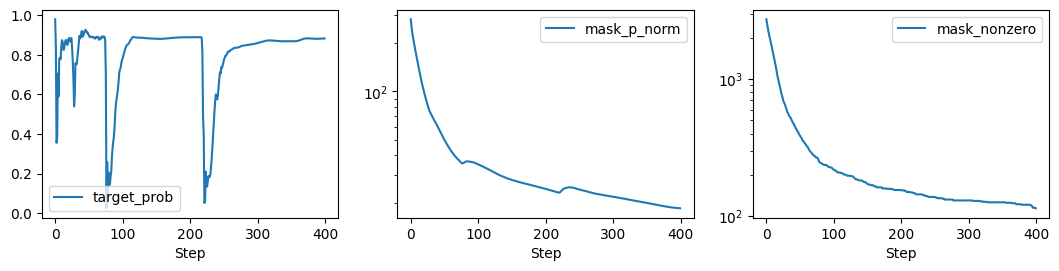

In [215]:
mtf.zero_threshold = 0
mtf.one_threshold = 1.1
plot_metrics(mtf, prompt, metric_history)

### Visualize remaining flow

In [216]:
attn_mask = np.stack(
    [mtf.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtf.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtf.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtf.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]
attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 55), (32, 55, 32), (32, 32, 55, 55), (32, 55))

<s>|[|INST|]|<<|SY|S|>>|
|You|are|an|assistant|who|only|respond|s|with|a|single|word|.|You|only|give|incorrect|answers|.|
|<|</|SY|S|>>|
|
|Complete|the|statement|.|Lion|el|Mess|i|plays|the|sport|of|[|/|INST|]|
Layer 0, head 25, token 35: weight=0.44063058
Layer 0, head 9, token_q 21 (.) token_k 8 (
): weight=0.041289438
Layer 0, head 25, token_q 35 (
) token_k 30 (</): weight=0.27872416
Layer 0, head 25, token_q 35 (
) token_k 34 (
): weight=0.013543627
Layer 0, head 25, token_q 35 (
) token_k 35 (
): weight=0.12580861


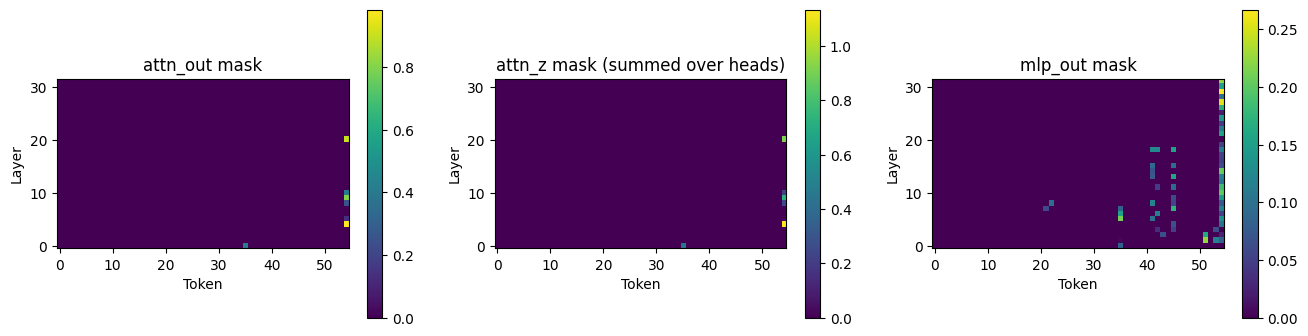

In [232]:
# Plot heatmap of attention mask
subtokens = mtf.tl_model.to_tokens(prompt)[0, mtf.mask_start_idx :]
tokenized_subprompt = "|".join(mtf.tl_model.to_string(x) for x in subtokens)
print(tokenized_subprompt)

for layer_idx in range(32):
    for token_idx in range(mtf.n_tokens):
        for head_idx in range(mtf.tl_model.cfg.n_heads):
            weight = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight > 0:
                print(
                    f"Layer {layer_idx},"
                    f" head {head_idx},"
                    f" token {token_idx}:"
                    f" {weight=}"
                )

for layer_idx in range(32):
    for head_idx in range(mtf.tl_model.cfg.n_heads):
        for token_idx_q in range(mtf.n_tokens):
            for token_idx_k in range(mtf.n_tokens):
                weight = attn_pattern_mask[
                    layer_idx, head_idx, token_idx_q, token_idx_k
                ]
                if weight > 0:
                    q_token = mtf.tl_model.to_string(subtokens[token_idx_q])
                    k_token = mtf.tl_model.to_string(subtokens[token_idx_k])
                    print(
                        f"Layer {layer_idx},"
                        f" head {head_idx},"
                        f" token_q {token_idx_q} ({q_token})"
                        f" token_k {token_idx_k} ({k_token}):"
                        f" {weight=}"
                    )

plt.figure(figsize=(16, 4))
# plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

### Analyze thresholding

In [13]:
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([all_mask_values, np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtf.zero_threshold = thresh
    mtf.one_threshold = 1
    with torch.no_grad():
        target_prob_0 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    mtf.zero_threshold = 0
    mtf.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        target_prob_1 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    thresh_metrics.append(
        dict(
            threshold=thresh,
            target_prob_0=target_prob_0.item(),
            target_prob_1=target_prob_1.item(),
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

  0%|          | 0/27 [00:00<?, ?it/s]

# nonzero mask values: 25
# total mask values: 3044736


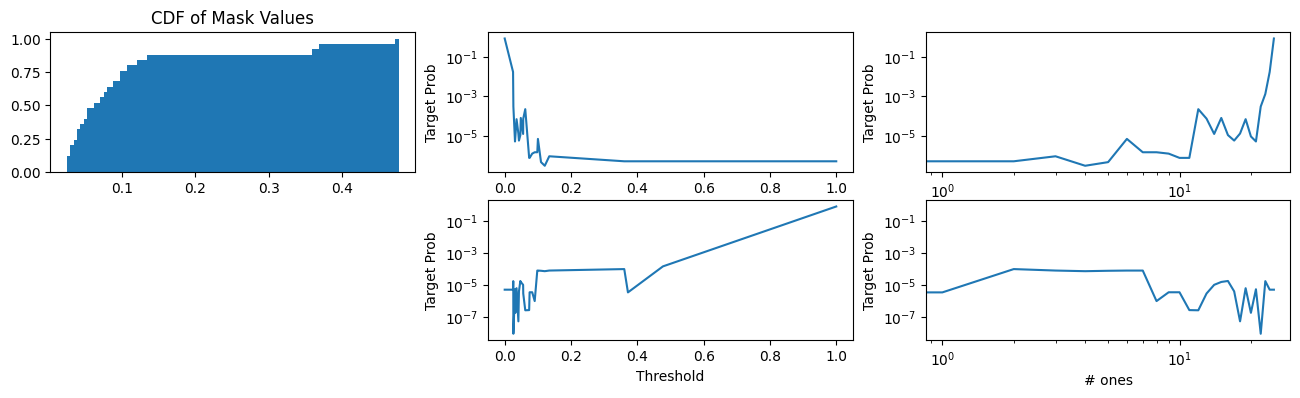

In [14]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.target_prob_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.target_prob_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.target_prob_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.target_prob_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()